Author: Jack Farrell

# Preliminary

This notebook tries to reproduce the results of Fig. 2 in Mendl et al. 2019.  They claim that hydrodynamic electrons satisfying certain boundary conditions act as a nonlinear oscillator in the Terahertz range.

## Equations
The equations are the isothermal equations of gas dynamics, with a couple extra terms that I put on the RHS.  In their non-dimensional form, they look like:

$$\partial_t J + \partial_x \left(n + \frac{J^2}{n} \right) = \eta \partial^2_x \left(\frac{J}{n}\right) + \gamma (n v_0 - J),$$

$$\partial_t n + \partial_x J = 0.$$

So they are the Navier-Stokes equation and the continuity equation.  The term $\partial_xn$ in the Navier-Stokes equation comes from assuming a simple form for the pressure.  The weird boundary conditions are:

$$n(0) = 1,$$
$$\partial_xJ(0) = 0,$$
$$J(1) = v_0.$$

We choose parameters $\eta = 0.02$, $\gamma = 0.04$, $v_0 = 0.14$.

## Numerical Method
### Conservation Law
If you forget about the terms on the RHS of the Navier-Stokes equation, we can write the remaining stuff as a *vector conservation law*.  A conservation law has the form: $\partial_t \vec{u} + \partial_x \vec{f}(\vec{u}) = 0$, where $\vec{u}$ is a state vector and $\vec{f}$ is the "flux vector".  In our case, the conservation law is is:
$$\partial_t \begin{pmatrix}n \\ J \end{pmatrix} + \partial_x \begin{pmatrix} J \\ \frac{J^2}{n} + n\end{pmatrix} = 0.$$
Conservation laws are handled well by finite volume methods, so we'll use one of those.  But we have to still deal with the other stuff that is not part of the conservation law. For the dissipative term with $\eta$, we'll directly incorporate it in the time-stepping as a finite differences quotient.  For the relaxation term with $\gamma$, we'll employ an approach called "operator splitting", specifically, "Strang Splitting".

### Relaxation Step
Pretend the Navier-Stokes equation only has the term with $\gamma$.  Then it's an ODE that reads:

$$\partial_t J = \gamma(nv_0-J).$$

You can solve this one exactly, and the answer is $J(t) = nv_0 + (J_0 - nv_0)e^{-\gamma t}$.  So this step we can perform exactly!


# Simulation

In [1]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

In [2]:
#Settings
imageLog = True #during the simulation, will plot a graph every 1.0 sec of sim time so you can check on it
saveFigures = True #If true, will save pdfs of all figures

In [3]:
#Global things
eps = np.finfo(float).eps #machine epsilon
k = 0.001 #Time Step
h = 1/50. #Mesh width
T = 152.0 #stopping time

In [4]:
#Define Helper Functions
def minmod(a,b):
    """
    The minmod function gives a simple way of doing slope-limiting (used in the high resolution correction)
    """
    if np.abs(a) < np.abs(b) and a * b > 0:
        return a
    elif np.abs(b) < np.abs(a) and a * b > 0:
        return b
    else:
        return 0
    
def maxmod(a,b):
    """
    Helper function for superbee limiter
    """
    if np.abs(a) > np.abs(b) and a * b > 0:
        return a
    elif np.abs(b) > np.abs(a) and a * b > 0:
        return b
    else:
        return 0

def superbee(a,b):
    """
    A less diffusive slope-limiter
    """
    s1 = minmod(b, 2*a)
    s2 = minmod(2 * b, a)
    
    return maxmod(s1, s2)

#Select which slope-limiter
slopeLimiter = superbee 

def eigenExpand(uleft, uright):
    """
    Expands jump in state vector from cell to cell in terms of
    the eigenfunctions of the Roe matrix 'A' which is hard
    coded in.  uL and uR should be two-component state vectors, 
    i.e., numpy arrays with 2 components.
    """
    nleft, Jleft = uleft
    nright, Jright = uright
    jump_in = uright - uleft
    v_in =(nleft**0.5*Jleft/(nleft) + nright**0.5*Jleft/(nright))/(nleft**0.5 + nright**0.5)
    #Want to solve for "alpha1, alpha2", the coefficients of each eigenvector
    #in the expansion of the jump.  We do that here!
    alpha1_in = (jump_in[0] * (v_in + 1) - jump_in[1])/2
    alpha2_in = (-jump_in[0] * (v_in - 1) + jump_in[1])/2
    
    return alpha1_in, alpha2_in

def f(u):
    """
    flux term in equation.  In our case, the it is a vector [J, J**2/n + n].
    Just a convenience function that does this calcul
    """
    n_in, J_in = u
    return np.array([J_in,J_in**2/n_in + n_in])

def flux(uL, uR, UL, UR):
    """
    Finite volume methods approximate the average of the solution on a bunch of
    cells.  The averages are updated by the "flux" through the boundaries of the
    cell.  This function computes the flux at the boundary between uL and uR.  
    Because of the high resolution method used, the values at one previous cell,
    UL and UR are also needed.
    """
    nL, JL = uL
    nR, JR = uR
    jump = uR - uL
    #rho averaged velocity
    v = (nL**0.5*JL/(nL+eps) + nR**0.5*JR/(nR))/(nL**0.5 + nR**0.5)
    #Hard-code eigenvectors and eigenvalues (from [3])
    r1 = [1, v - 1]
    w1 = v - 1
    r2 = [1, v + 1]
    w2 = v + 1
    alpha1, alpha2 = eigenExpand(uL, uR)
    
    #Get the gobunov flux
    fG = f(uL) + min(w1, 0) *  alpha1 * np.array(r1) + min(w2, 0) * alpha2 * np.array(r2)
    
    #For next part, need the "j - 1" value of the alpha1, alpha2 expansion
    #coefficients.  I give these new variable names by switching the case
    #of everything
    NL, jL = UL
    NR, jR = UR
    Jump = UR - UL
    V = (NL**0.5*jL/NL + NR**0.5*jR/NR)/(NL**0.5 + NR**0.5)
    R1 = [1, V - 1]
    W1 = V - 1
    R2 = [1, V + 1]
    W2 = V + 1
    Alpha1, Alpha2 = eigenExpand(UL, UR)
    
    #Here's the slope limiting thing
    sigma1 = 1/h*np.array(
    [slopeLimiter(alpha1 * r1[0], Alpha1 * R1[0]), slopeLimiter(alpha1 * r1[1], Alpha1 * R1[1])])
    
    sigma2 = 1/h*np.array(
    [slopeLimiter(alpha2 * r2[0], Alpha2 * R2[0]), slopeLimiter(alpha2 * r2[1], Alpha2 * R2[1])])
    
    #The high resolution correction to the flux:
    additionalFlux = 1/2 * (w1 * (np.sign(k * w1 / h) - k * w1 / h) * h * sigma1 + w2 * (np.sign(k * w2 / h) - k * w2 / h) * h * sigma2)
    
    F = fG + additionalFlux
    
    return F

Time is 0.000 out of 152.000 - - - - Iteration 0


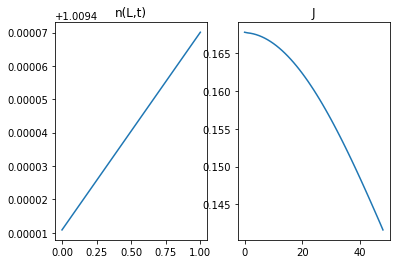

Time is 0.500 out of 152.000 - - - - Iteration 500
Time is 1.000 out of 152.000 - - - - Iteration 1000


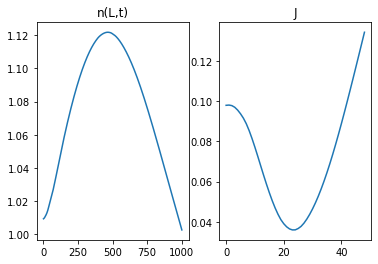

Time is 1.500 out of 152.000 - - - - Iteration 1500
Time is 2.000 out of 152.000 - - - - Iteration 2000


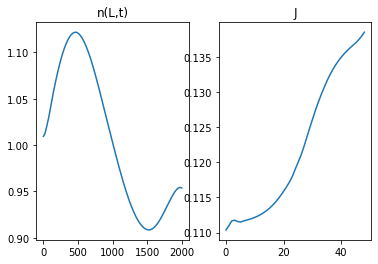

Time is 2.500 out of 152.000 - - - - Iteration 2500
Time is 3.000 out of 152.000 - - - - Iteration 3000


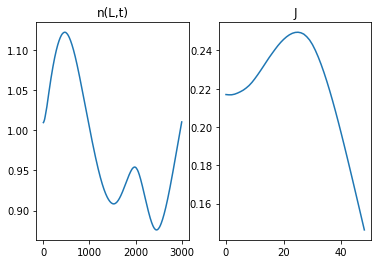

Time is 3.500 out of 152.000 - - - - Iteration 3500
Time is 4.000 out of 152.000 - - - - Iteration 4000


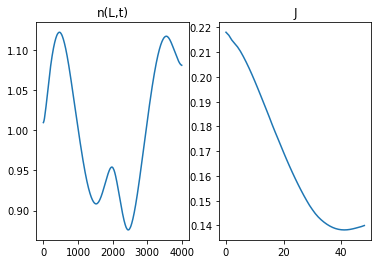

Time is 4.500 out of 152.000 - - - - Iteration 4500
Time is 5.000 out of 152.000 - - - - Iteration 5000


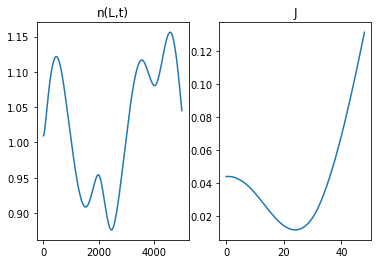

Time is 5.500 out of 152.000 - - - - Iteration 5500
Time is 6.000 out of 152.000 - - - - Iteration 6000


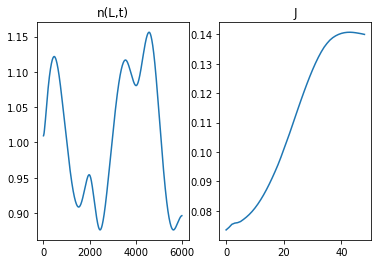

Time is 6.500 out of 152.000 - - - - Iteration 6500
Time is 7.000 out of 152.000 - - - - Iteration 7000


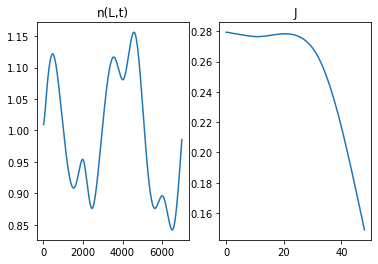

Time is 7.500 out of 152.000 - - - - Iteration 7500
Time is 8.000 out of 152.000 - - - - Iteration 8000


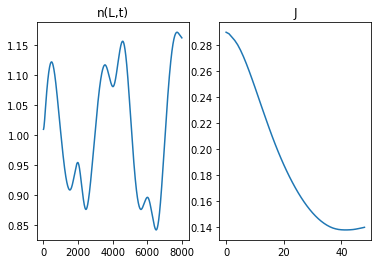

Time is 8.500 out of 152.000 - - - - Iteration 8500
Time is 9.000 out of 152.000 - - - - Iteration 9000


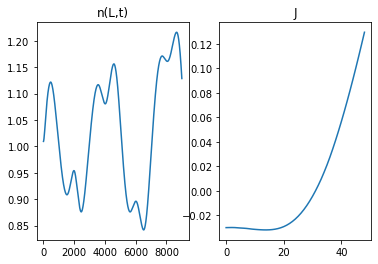

Time is 9.500 out of 152.000 - - - - Iteration 9500
Time is 10.000 out of 152.000 - - - - Iteration 10000


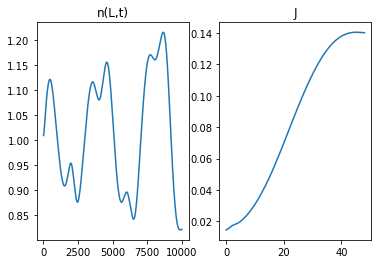

Time is 10.500 out of 152.000 - - - - Iteration 10500
Time is 11.000 out of 152.000 - - - - Iteration 11000


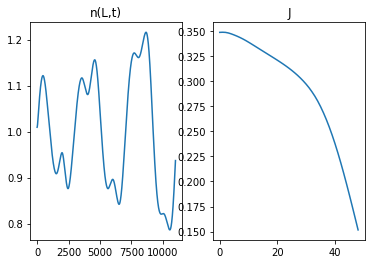

Time is 11.500 out of 152.000 - - - - Iteration 11500
Time is 12.000 out of 152.000 - - - - Iteration 12000


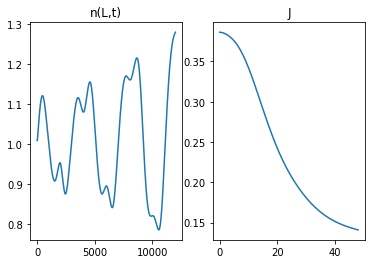

Time is 12.500 out of 152.000 - - - - Iteration 12500
Time is 13.000 out of 152.000 - - - - Iteration 13000


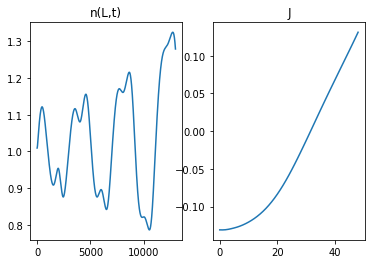

Time is 13.500 out of 152.000 - - - - Iteration 13500
Time is 14.000 out of 152.000 - - - - Iteration 14000


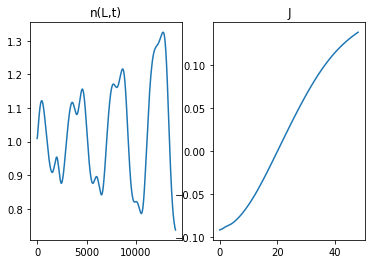

Time is 14.500 out of 152.000 - - - - Iteration 14500
Time is 15.000 out of 152.000 - - - - Iteration 15000


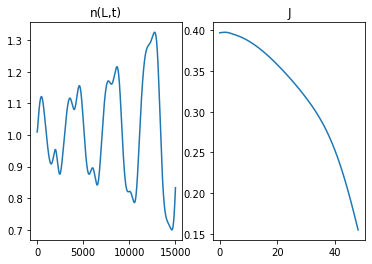

Time is 15.500 out of 152.000 - - - - Iteration 15500
Time is 16.000 out of 152.000 - - - - Iteration 16000


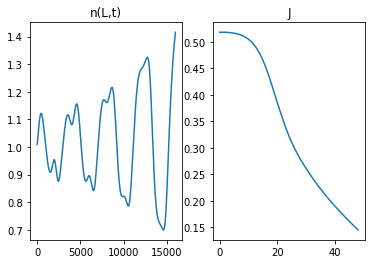

Time is 16.500 out of 152.000 - - - - Iteration 16500
Time is 17.000 out of 152.000 - - - - Iteration 17000


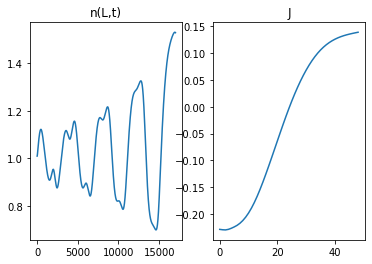

Time is 17.500 out of 152.000 - - - - Iteration 17500
Time is 18.000 out of 152.000 - - - - Iteration 18000


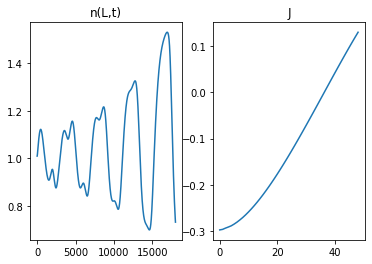

Time is 18.500 out of 152.000 - - - - Iteration 18500
Time is 19.000 out of 152.000 - - - - Iteration 19000


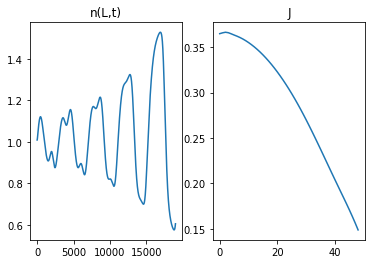

Time is 19.500 out of 152.000 - - - - Iteration 19500
Time is 20.000 out of 152.000 - - - - Iteration 20000


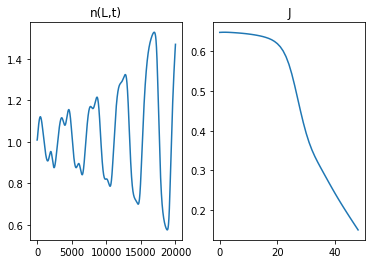

Time is 20.500 out of 152.000 - - - - Iteration 20500
Time is 21.000 out of 152.000 - - - - Iteration 21000


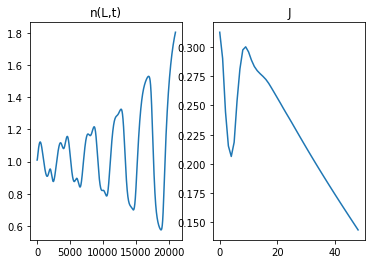

Time is 21.500 out of 152.000 - - - - Iteration 21500
Time is 22.000 out of 152.000 - - - - Iteration 22000


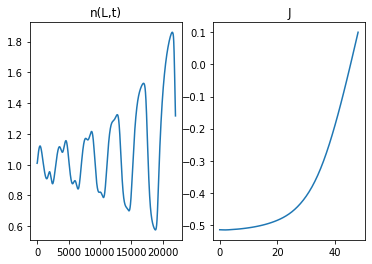

Time is 22.500 out of 152.000 - - - - Iteration 22500


In [ ]:
#Set up the domain of the problem in space and time.
x = np.arange(0., 1.0, h)
tau = np.arange(0., T, k)

#like to do computations at midpoints for finite volume methods
xMid = x[:-1] + h / 2

#Parameters
v0 = 0.14 #dimensionless velocity
eta = 0.01 #dimensionless viscosity
gamma = 0.04 #dimensionless momentum relaxation rate

n0 = 1. + 0.1 * np.sin(xMid*np.pi)
J0 = v0 * (1. + 0.2 * np.cos(np.pi * xMid / 2))

u = np.vstack((n0, J0)).T

#Storage
J_list = []
n_list = []

J_list.append(np.copy(u[:,1]))
n_list.append(np.copy(u[:,0]))
N = 0

for t in np.arange(0, T, k):
     #First part of the Strang Splitting - integrate the relaxation term up to
    #dt / 2
    
        
    #Now impose boundary conditions on left and right!
    uLeft = np.array([[1.,u[2][1]], [1.,u[1][1]]])
    uRight = np.array([[2*u[-1][0] - u[-2][0], v0], [u[-1,0], v0]])
    u[:,1] = u[:,0] * v0 + (u[:,1] - u[:,0] * v0) * np.exp(-gamma * k / 2)
                     
    uBC = np.vstack((uLeft, u, uRight))
    U = np.copy(u)
    #the uBC array has the real physical domain and also some extra "ghost" cells used to
    #do the boundary conditions.
    n = uBC[:,0] #just useful
    J = uBC[:,1]
    q = J / n

    for j in range(2, uBC.shape[0] - 2): #iterate through the *physical* domain
        #Call the flux() function at the left and right boundary of each cell
        FMinus = flux(uBC[j - 1], uBC[j], uBC[j - 2], uBC[j - 1])
        FPlus = flux(uBC[j], uBC[j + 1], uBC[j - 1], uBC[j])
        
        #Approximate the dissipative term by a finite differences quotient (2nd order)
        dissipative = k * np.array([0, eta * 1/h**2 * (q[j + 1] - 2 * q[j] + q[j - 1])])
        
    
        #Update each element of physical domain
        U[j-2] = u[j-2] - k / h * (FPlus - FMinus) + dissipative # + 0.0075 * k * 1/h**2 * (uBC[j + 1] - 2*uBC[j] + uBC[j - 1])
        #Note the last term in the above is the-made up viscous term!
        
    #Second step of Strang Splitting, same integration
    U[:,1] = U[:,0] * v0 + (U[:,1] - U[:,0] * v0) * np.exp(-gamma * k / 2)

    #send to the storage lists
    J_list.append(np.copy(U[:,1]))
    n_list.append(np.copy(U[:,0]))
    u = np.copy(U)
    
    #Log Progress
    if N % 500 == 0:
        print("Time is {:.3f} out of {:.3f} - - - - Iteration {}".format(t, T, N))
    if N % 1000 == 0 and imageLog:
        fig, axes = plt.subplots(1,2)
        ax1, ax2 = axes
        ax1.plot([list[-1] for list in n_list])
        ax1.set_title("n(L,t)")
        ax2.plot(J_list[-1])
        ax2.set_title("J")
        plt.show()
    N += 1


# Results

In [ ]:
#Figures
from matplotlib import rc
import matplotlib.ticker as tckr
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

#Matplotlib Parameters
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=12)

#Mendl et al. Fig. 2
fig2, axes2 = plt.subplots(1,1, figsize = (4,4))
ax21 = axes2
ax21.grid()
ax21.plot(tau[:80/k.], [list[-1] for list in n_list][:-1],lw = 1, color = "Black")
ax21.set_xlabel("$v_s t / L$")
ax21.set_ylabel("$n(L,t)/n_0$")
fig2.tight_layout()
if saveFigures:
    plt.savefig("Figures/resonance_superbee.pdf")
plt.show()

#Mendl et. al Fig. 3 (Used different time for snapshots b.c. I only ran 80.0 seconds of sim time)
fig3, axes3 = plt.subplots(2, 5, figsize = (10,5), sharex = True, sharey = True)
J_snapshots = []
n_snapshots = []
delta = 0.5 #time difference between snapshots in seconds
start = 147. #time to start snapshots in seconds
for number in range(10):
    index = int((start + delta * number) / k)
    J_snapshots.append(J_list[index])
    n_snapshots.append(n_list[index])
index = 0
for i in axes3:
    for axis in i:
        axis.grid()
        axis.plot(xMid, n_snapshots[index], label = "$n/n_0$")
        axis.plot(xMid, J_snapshots[index], label = "$J/n_0v_s$")
        axis.set_title("$v_st/L = {:.1f}$".format(start + delta * index))
        index += 1
for axis in axes3[-1]:
    axis.set_xlabel("$x/L$") #Set label only on the bottom axes
axes3[0,0].legend()
fig3.tight_layout()
if saveFigures:
    plt.savefig("Figures/snapshots_superbee.pdf")
plt.show()

## Quick Discussion
So, I'll note a couple things quickly about the results... chiefly, they don't look *exactly* the same as the paper's figures.  I think part of this is just the particular initial conditions I chose, but I worry some of it is the smoothing term I had to add.  The two differences that stand out to me are:
1. smoothness of resonance.  In Fig. 2 of [1], especally at the beginning, the peaks are sharper and less regular.  My graph gets a little bit of that in the first trough, but then it smooths out quickly.

2. steepness of "kinks" in the snapshots - much more pronounced than in Fig. 3 of [1].  This could be just the initial conditions, or it could also be that I show snapshots at 60.0 sec instead of 147.0 sec like [1], but I worry it is the diffusive effect of my made-up viscosity.

# References

1. Mendl, C. B., Polini, M., & Lucas, A. (2019). Coherent Terahertz Radiation from a Nonlinear Oscillator of Viscous Electrons. Retrieved from http://arxiv.org/abs/1909.11093
2. LeVeque, R. (2002). Finite Volume Methods for Hyperbolic Problems (Cambridge Texts in Applied Mathematics). Cambridge: Cambridge University Press. doi:10.1017/CBO9780511791253
3. LeVeque, R. J. (1992). Numerical methods for conservation laws. Basel: Birkhäuser. doi: DOI https://doi.org/10.1007/978-3- 0348-8629-1